In [1]:
#essential imports
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

#scraping imports
import requests
from bs4 import BeautifulSoup

#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt

#String matching
import re

# Date
import datetime as dt
# Sleep
import time

# Strict JSON conversion
import json 
import gzip 

# Progress display
from IPython.display import clear_output

# Amazon API querying
from amazon.api import AmazonAPI
from amazon.api import AsinNotFound

#garbage collector
import gc

cps = 4
datapath = 'DATA/review_filtered/'
f_subjects = datapath+'movie_reviews_matched_'+str(cps)+'cps.csv'
f_controls = datapath+'movie_reviews_matched_'+str(cps)+'cps_ctrls.csv'

# Load data

In [2]:
subjects_actors = pd.read_csv(f_subjects).drop('Unnamed: 0',axis=1)
subjects_actors = subjects_actors.rename(columns={'reviewTime' : 'strReviewTime'})
subjects_actors.head(3)

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03


In [3]:
controls_actors = pd.read_csv(f_controls).drop('Unnamed: 0',axis=1)
controls_actors = controls_actors.rename(columns={'reviewTime' : 'strReviewTime'})
controls_actors.head(3)

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name
0,827321,630327417X,2009-10-15,5.0,"[0, 1]",Great Movie,Nothing bad to say. Dvd came quickly and in gr...,michael hynson
1,827322,630327417X,2000-09-16,5.0,"[0, 0]",endless summer,its just to good for words!,michael hynson
2,827323,630327417X,2005-03-03,1.0,"[5, 58]",A very disappointed lover of documentaries,I feel obligated to warn you-as I wish I was w...,michael hynson


# Convert dates to timestamps / years

Convert dates to year and extract and set aside actor<-> deathdates

In [4]:
#counts = subjects_actors.groupby('actor name').count()
#subjects_actors['death date'] = pd.to_datetime('2001').year

''' Takes a serie !
'''
def strdateToYear(date) : 
    return int(date[:4])

# SUBJECTS
subjects_actors['reviewYear'] = subjects_actors['strReviewTime'].apply(strdateToYear)
subjects_actors['reviewTime'] = pd.to_datetime(subjects_actors['strReviewTime'])
subjects_actors['death year'] = subjects_actors['death date'].apply(strdateToYear)
subjects_actors['death date'] = pd.to_datetime(subjects_actors['death date'])

# CONTROLS
controls_actors['reviewYear'] = controls_actors['strReviewTime'].apply(strdateToYear)
controls_actors['reviewTime'] = pd.to_datetime(controls_actors['strReviewTime'])

Extract death dates and subjects names

In [5]:
deathdates = subjects_actors.groupby(['actor name','death date', 'death year']).count()\
                            .reset_index()[['actor name', 'death date', 'death year']]
sbj_names = list(deathdates['actor name'])
deathdates.head()

,actor name,death date,death year
0,adriana caselotti,1997-01-19,1997
1,adrienne shelly,2006-11-01,2006
2,al martino,2009-10-13,2009
3,alain bashung,2009-03-14,2009
4,alan bates,2003-12-27,2003


Extract controls names

In [6]:
ctrl_names = list(set(controls_actors['actor name']))

# Pre-filtering

### Filtering on populatiry

Filter actors based on their popularity: they should be mentioned at least once in the reviews. It is a way to be sure the reviewers know the actor.

In [7]:
thresh_pop = 1

def mentionsName(row) : 
    if type(row['reviewText']) is str :
        names = row['actor name'].split(' ')
        text =  row['reviewText'].lower()
        # can mention only name or surname
        #return row['actor name'] in row['reviewText']
        for name in names : 
            if name in text : 
                return True
        return False
    else : return False

In [8]:
subjects_actors['mentionned'] = subjects_actors.apply(mentionsName, axis=1)
subjects_actors.shape, subjects_actors[subjects_actors['mentionned']==True].shape

((597276, 13), (130234, 13))

In [9]:
## Not necessarily needed, count of mentions are still in the reviews dataframe
##
sbj_popular = subjects_actors[subjects_actors['mentionned']==True]
sbj_popular = sbj_popular.groupby('actor name').count()['asin']
print(len(sbj_names), " reduced to", sbj_popular.shape)
sbj_popular.sort_values(ascending=False)[:10]

501  reduced to (460,)


actor name
james stewart        4135
paul newman          3119
charlton heston      3031
gregory peck         2618
marlon brando        2592
jack lemmon          2367
james garner         2347
katharine hepburn    2293
robert mitchum       2089
charles bronson      2028
Name: asin, dtype: int64

In [10]:
controls_actors['mentionned'] = controls_actors.apply(mentionsName, axis=1)
controls_actors.shape, controls_actors[controls_actors['mentionned']==True].shape

((285071, 11), (42178, 11))

In [11]:
## Not necessarily needed, count of mentions are still in the reviews dataframe
##
ctl_popular = controls_actors[controls_actors['mentionned']==True]
ctl_popular = ctl_popular.groupby('actor name').count()['asin']
print(len(ctrl_names), " reduced to", ctl_popular.shape)
ctl_popular.sort_values(ascending=False)[:10]

2419  reduced to (1215,)


actor name
matt damon            6017
steve martin          3266
tyler perry           2870
ian anderson          1213
laurence fishburne    1198
liev schreiber        1060
michelle williams     1058
marc m                 896
maggie gyllenhaal      867
robert taylor          749
Name: asin, dtype: int64

### Filtering on date (2004-2013)

In [12]:
start = 1996
end = 2014

print('original size : ', subjects_actors.shape)
subjects_inTime = subjects_actors[    (subjects_actors['death year']>=start) \
                                    & (subjects_actors['death year']<=end)]
print('filtered size : ', subjects_inTime.shape)
subjects_inTime.head(3)

original size :  (597276, 13)
filtered size :  (597276, 13)


,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date,reviewYear,reviewTime,death year,mentionned
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03,2006,2006-04-07,1996,False
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03,2013,2013-03-24,1996,False
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03,2014,2014-04-05,1996,False


# Get matching features

Extract features for subjects

In [13]:
# SUBJECTS COUNTS BY YEAR
subjects_revs = subjects_actors.groupby(['actor name','reviewYear']).count()


def getreview(actor, year) : 
    try : 
        val = subjects_revs.loc[actor, year]['asin']
        return val
    except TypeError :
        return 0
    

# FILTER TO GET THE DEATH YEAR COUNT - 1
subjects_feats = deathdates[1:].apply(lambda row : getreview(row['actor name'], int(row['death year'])-1), axis=1)
subjects_feats = pd.DataFrame(subjects_feats, columns=['reviews'])
subjects_feats['actor name'] = deathdates['actor name']
subjects_feats['death year'] = deathdates['death year']

subjects_feats.sort_values(by='reviews', ascending=False).head()

,reviews,actor name,death year
228,2054,james garner,2014
389,1550,philip seymour hoffman,2014
357,1425,mickey rooney,2014
140,1112,eli wallach,2014
51,1057,bob hoskins,2014


Extract features for subjects

In [14]:
controls_revs = controls_actors.groupby(['actor name','reviewYear'])\
                                .count()['asin']\
                                .to_frame().reset_index()

In [15]:
controls_revs.sort_values(by=['actor name', 'asin'], ascending=False).head()

,actor name,reviewYear,asin
12911,zuzana parmova,2001,1
12912,zuzana parmova,2004,1
12905,zuhal gencer,2005,6
12907,zuhal gencer,2007,5
12906,zuhal gencer,2006,4


# Matching

Construct a matching function per subject

In [16]:
def match(actorname, threshold, ctrl_revs) : 

    # extract the useful features for the subject 
    sbj_actor = subjects_feats[subjects_feats['actor name'] == actorname]
    deathyear = int(sbj_actor['death year'])
    sbj_revs = int(sbj_actor['reviews'])
    
    #find the non zero reviews count for the year preceding the death of the subject
    mapp = (ctrl_revs['reviewYear']==(deathyear-1))
    
    
    if (sbj_revs == 0) and (not ctrl_revs[mapp==False].empty):
        
        # zero count subjects are matched with zero count controls 
        matched_name = ctrl_revs[mapp==False].reset_index()['actor name'].get_value(0)
        matched_count = 0
        
        # delete the matched control 
        ctrl_revs = ctrl_revs[ctrl_revs['actor name'].isin([matched_name])==False]
        
        return matched_name, matched_count, ctrl_revs
    
    
    if mapp.any():
        
        for row in ctrl_revs[mapp].iterrows():
            #print(np.abs(sbj_revs-row[1]['asin']))
                   
            if np.abs(sbj_revs-row[1]['asin']) < threshold :
                
                matched_name = row[1]['actor name']
                matched_count = row[1]['asin']
                
                # delete the matched control
                ctrl_revs = ctrl_revs[ctrl_revs['actor name'].isin([matched_name])==False]
                
                return matched_name, matched_count, ctrl_revs
    else:
        
        matched_name = ctrl_revs.reset_index()['actor name'].get_value(0)
        matched_count = 0
        
        #delete the matched control
        ctrl_revs = ctrl_revs[ctrl_revs['actor name'].isin([matched_name])==False]
        
        return matched_name, matched_count, ctrl_revs
    
    
    return 0, 0, ctrl_revs  


In [17]:
ctrl_revs = controls_revs.copy()

print(len(ctrl_names), len(sbj_names))

2419 501


In [18]:
thresh = 5
ctrl_revs = controls_revs.copy()
sorted_subjects = subjects_feats.sort_values(by='reviews', ascending=False)
ctrl_list = [] # stores the name of matched controls
count_list = [] # stores the features of matched controls
matchings = []

for idx, subject_name in enumerate(sorted_subjects['actor name']):
    
    if idx%50 == 0: 
        print(idx, "out of ", len(subjects_feats['actor name']))
    
    mtch = 0
    thr = thresh

    while mtch == 0:
        
        thr += int(0.25*thr)
        
        if thr > 50 and thr < 70  : 
            print(subject_name+' reached threshold ', thr)
        if thr > 1000 and thr < 1499  : 
            print(subject_name+' reached threshold ', thr)
        if thr > 10000 : 
            print(subject_name+' reached threshold > 10000 (won\'t match)')
        
        name, count, ctrl_revs_ = match(subject_name,thr,ctrl_revs)
        ctrl_revs = ctrl_revs_.sample(frac=1) 
        
        
        if name != 0:
            #rint(subject_name+' matched with '+name)
            
            ctrl_list.append(name)
            count_list.append(count)
            matchings.append((subject_name, name))
            mtch += 1

0 out of  500
james garner reached threshold  51
james garner reached threshold  63
philip seymour hoffman reached threshold  51
philip seymour hoffman reached threshold  63
mickey rooney reached threshold  51
paul newman reached threshold  51
paul newman reached threshold  63
george carlin reached threshold  51
george carlin reached threshold  63
charlton heston reached threshold  51
charlton heston reached threshold  63
dennis hopper reached threshold  51
andy whitfield reached threshold  51
andy whitfield reached threshold  63
leslie nielsen reached threshold  51
leslie nielsen reached threshold  63
ernest borgnine reached threshold  51
andy griffith reached threshold  51
andy griffith reached threshold  63
peter falk reached threshold  51
peter falk reached threshold  63
jack lemmon reached threshold  51
jack lemmon reached threshold  63
50 out of  500
100 out of  500
150 out of  500
200 out of  500
250 out of  500
300 out of  500


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


350 out of  500
400 out of  500
450 out of  500


# Results

In [19]:
ctrl_features = pd.DataFrame(ctrl_list, columns=['ctrl_name'])
ctrl_features['ctrl_reviews'] = count_list

res = pd.concat([ctrl_features.reset_index(), sorted_subjects.reset_index()], axis=1)\
            .drop('index', axis=1)
res['error'] = np.abs(res['ctrl_reviews'] - res['reviews'])/(2*(1+res['ctrl_reviews'] + res['reviews']))

res.sort_values(by='error', ascending=False).head()

,ctrl_name,ctrl_reviews,reviews,actor name,death year,error
297,aidan kelley,6,1,nagisa oshima,2013,0.312500
246,lucien bruchon,1,6,jules dassin,2008,0.312500
243,firesign theater,1,6,michelangelo antonioni,2007,0.312500
249,charles cane,1,5,simone simon,2005,0.285714
248,nagatoshi sakamoto,1,5,glenn quinn,2002,0.285714


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcd6b20a20>]], dtype=object)

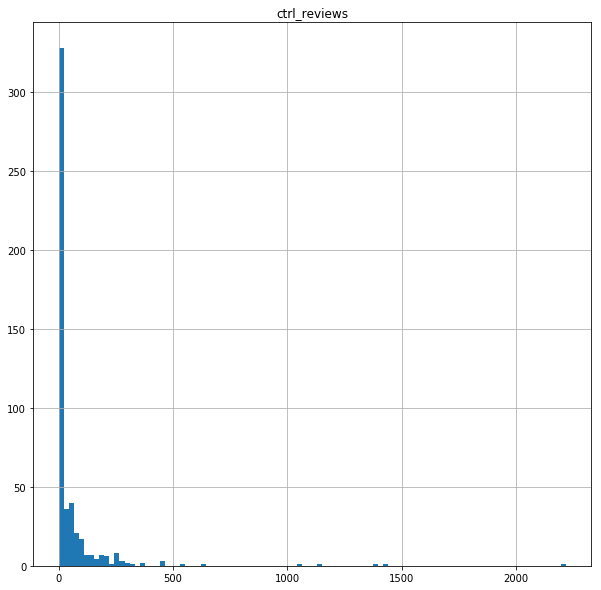

In [20]:
ctrl_features.hist(column='ctrl_reviews', figsize=[10,10], bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcdee6f588>]], dtype=object)

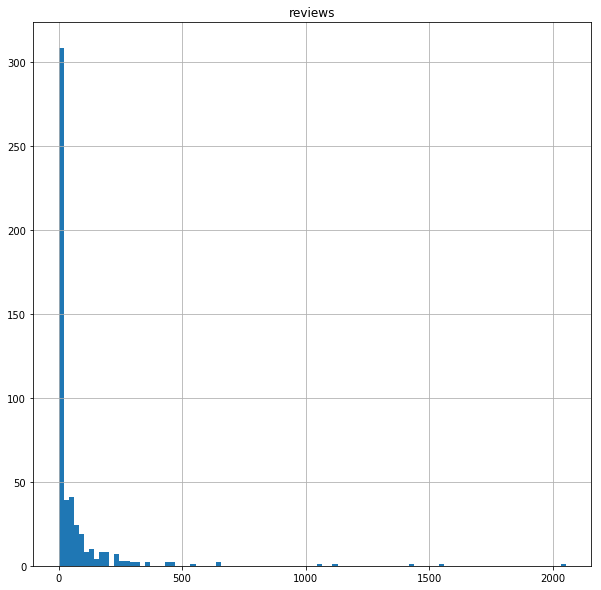

In [21]:
subjects_feats.hist(column='reviews', figsize=[10,10], bins=100)

# Export results

In [22]:
subjectsnb = str(len(sbj_names)-1)

In [23]:
subjects_actors.to_csv('DATA/reviews_cs_matched/reviews_subjects_'+subjectsnb+'.csv', index=False)

In [24]:
controls_actors.to_csv('DATA/reviews_cs_matched/reviews_controls_'+subjectsnb+'.csv', index=False)

In [25]:
res.to_csv('DATA/reviews_cs_matched/matchings_'+subjectsnb+'_feature=yearbefore.csv', index=False)